# 挂载Google Drive

连接并挂载Google Drive，切换工作目录到数据储存目录。

In [6]:
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from keras.models import load_model
import tensorflow as tf
import numpy as np
import os, cv2, csv

if os.name == 'posix':                             # Linux
    from google.colab import drive
    drive.mount('/content/drive')                       # 挂载Google Drive
    os.chdir('/content/drive/MyDrive/Juglans')                # 切换工作目录
    os.listdir()

    tf.test.gpu_device_name()                         # 测试GPU
    !/opt/bin/nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: /opt/bin/nvidia-smi: No such file or directory


# 数据增强

## 翻转
通过翻转图像和转向角度，网络能够学习这两种情况，并且不会偏向左转或右转。

In [ ]:
def flip(img):
    return cv2.flip(img, 0)

## 随机亮度调整
随机调整图像的亮度有助于模型更好地泛化到更多光照情况。

In [ ]:
def adjust_brightness_RGB(img):
    """
    Adjust brightness of the IMG, whose color is in RGB
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    ratio = 0.9 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

## 随机变换调整
左右随机变换图像有助于模型更好地泛化到更多未经训练的视角。

In [ ]:
def random_translate(image, steering_angle, range_x=100, range_y=10):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_y], [0, 1, trans_x]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

## 随机阴影
向左右图像随机添加阴影有助于模型更好地泛化到更多的情况，即一半的道路在树的阴影中，从而在同一条道路上出现不均匀的照明情况。这是丛林赛道较为突出的情况。

In [ ]:
def random_shadow(image):
    """
    Generates and adds random shadow
    """
    IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = image.shape
    x1, y1 = IMAGE_WIDTH * np.random.rand() / 4, 0
    x2, y2 = IMAGE_WIDTH * np.random.rand() / 4, IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1
    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.5, high=0.8)
    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)

# 数据处理

## 图像预处理
- 高斯模糊有助于减少图像噪声和细节，从而平滑训练数据（未使用）；
- opencv读取图片的默认像素排列是BGR，故需转换为RGB格式；
- 对图像进行归一化处理，将像素值压缩到-1到1。


In [14]:
def process_image(img, kernel_size=5):
    """
    Preprocess IMG with a Gaussian Blur;
    Convert it from BGR color channel to RGB color channel;
    Normalization.
    """
    # img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (160, 160))
    img = np.asarray(img)
    img = img.astype('float32')
    img /= 255
    return img

## 获取以及分析处理数据

In [17]:
def get_sample_data(path, random = True):
    """
    This function returns the data columns of the csv file at PATH
    """
    samples = []
    with open(path) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            line[0] = int(line[0])
            line[1] = float(line[1])
            line[2] = float(line[2])
            if (line[2] != 0):                                  # 过滤停车图像
                samples.append(line)
    return shuffle(samples) if random else samples

def analyze_samples(datas, column=1):
    """
    Return a dictionary containing count of all steering angles in DATA
    """
    angle_dict = dict()
    for data in datas:
        angle = round(data[column] * 10)
        if angle not in angle_dict:
            angle_dict[angle] = 1
        else:
            angle_dict[angle] += 1
    angle = dict()
    for key in sorted(angle_dict):
        angle[key] = angle_dict[key]
    return angle

def redistribute_samples(datas, count_map):
    """
    Return a new dataset by resampling DATA
    """
    average = np.average(list(count_map.values()))
    keep_prob = dict()
    for i in count_map:
        if count_map[i] <= average:
            keep_prob[i] = 1 # keep angles whose count <= than average
        else:
            # keep sample with a probability
            keep_prob[i] = average / count_map[i]
    # Resample Data
    new_data = list()
    for data in datas:
        angle = round(data[1] * 10)
        if np.random.random() <= keep_prob[angle]:
            new_data.append(data)
    # return np.array(new_data)
    return new_data

## 动态生成数据

In [ ]:
def generator(samples, directory, batch_size=32, preprocess_image=lambda x: x, augment=True):

    def read_img(path):
        return preprocess_image(cv2.imread(path))

    def append_data(lst1, item1, lst2, item2):
        lst1.append(item1)
        lst2.append(item2)

    def use_augmentation(prob):
        return True if np.random.random() <= prob else False

    def augment(new_img, new_angle):
        augmented = False
        if augment and use_augmentation(0.4):
            new_img, new_angle = adjust_brightness_RGB(new_img), new_angle
            augmented = True
        if augment and use_augmentation(0.2):
            new_img, new_angle = random_shadow(new_img), new_angle
            augmented = True
        if augment and use_augmentation(0.3):
            new_img, new_angle = random_translate(new_img, new_angle)
            augmented = True
        if not augmented or use_augmentation(0.4):
            new_img, new_angle = flip(new_img), -new_angle

        return new_img, new_angle
    
    def to_one_hot(value, fn=lambda x: round((x / 2 + 0.5) * 10), num_classes=11):
        one_hot_list = [0] * num_classes
        one_hot_list[fn(value)] = 1
        return one_hot_list

    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset: offset+batch_size]

            images = []
            steering = []
            for batch_sample in batch_samples:
                image = read_img("{}/{}.jpg".format(directory, int(batch_sample[0])))
                append_data(images, image, steering, batch_sample[1])
                # enhanced_img, batch_sample[1] = augment(image, batch_sample[1])
                # if batch_sample[1] > 1:
                #     batch_sample[1] = 1
                # elif batch_sample[1] < -1:
                #     batch_sample[1] = -1
                # append_data(images, image, steering, batch_sample[1])
                
            x_train = np.array(images)
            y_train = np.array(steering)
            yield shuffle(x_train, y_train)

# 构建模型

In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Cropping2D, Lambda
from keras_applications.mobilenet import MobileNet

def build_model(input_shape=(160, 160, 3)):
    model = Sequential()
    # model.add(Cropping2D(cropping=cropping_box, input_shape=input_shape))
    # model.add(Lambda(normalize_fn))
    # model.add(tf.keras.applications.MobileNet(
    model.add(MobileNet(
        input_shape = input_shape,
        alpha = 0.5,
        depth_multiplier = 1, 
        dropout = 0.001,
        include_top = False, 
        weights = "imagenet", 
        classes = 1000
    ))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='linear'))
    return model

# 训练模型

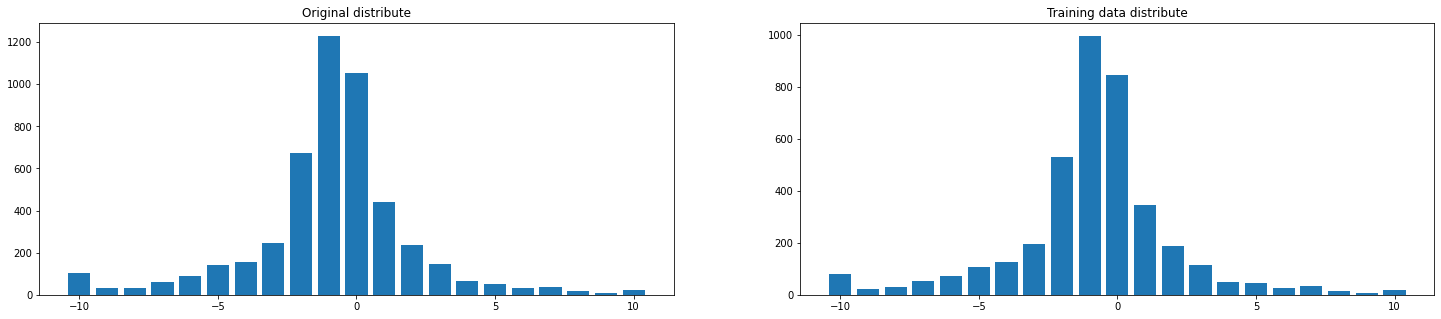

5586944/5577668 [==============================] - 0s 0us/step
Epoch 1/100
244/244 [==============================] - 1146s 5s/step - loss: 0.1275 - val_loss: 0.0553
Epoch 2/100
244/244 [==============================] - 30s 124ms/step - loss: 0.0565 - val_loss: 0.0542
Epoch 3/100
244/244 [==============================] - 30s 124ms/step - loss: 0.0490 - val_loss: 0.0457
Epoch 4/100
244/244 [==============================] - 30s 125ms/step - loss: 0.0410 - val_loss: 0.0402
Epoch 5/100
244/244 [==============================] - 30s 123ms/step - loss: 0.0332 - val_loss: 0.0308
Epoch 6/100
244/244 [==============================] - 30s 124ms/step - loss: 0.0271 - val_loss: 0.0309
Epoch 7/100
244/244 [==============================] - 30s 124ms/step - loss: 0.0228 - val_loss: 0.0256
Epoch 8/100
244/244 [==============================] - 30s 123ms/step - loss: 0.0197 - val_loss: 0.0222
Epoch 9/100
244/244 [==============================] - 30s 122ms/step - loss: 0.0173 - val_loss: 0.0224
Ep

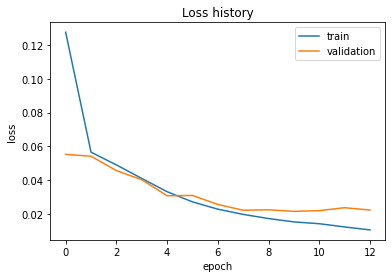

In [ ]:
from sklearn.model_selection import train_test_split

model_name = "model.h5"
data_path = "data"
samples = get_sample_data(data_path + "/output.csv")                     # 获取数据
train_samples, valid_samples = train_test_split(samples, test_size=0.2)            # 分割训练集与验证集

analyzeed_samples = analyze_samples(train_samples)                       # 分析数据，获取数据分布
train_samples = redistribute_samples(train_samples, analyzeed_samples)             # 对数据进行重新采样

train_generator = generator(train_samples, batch_size=16, directory=data_path, preprocess_image=process_image)
valid_generator = generator(valid_samples, batch_size=16, directory=data_path, preprocess_image=process_image)

plt.figure("Angle distribute", figsize=(25, 5))
plt.subplot(1, 2, 1)
plt.title("Original distribute")                                 # 原始数据分布
analyzeed_samples = analyze_samples(samples)
plt.bar(analyzeed_samples.keys(), analyzeed_samples.values())
plt.subplot(1, 2, 2)
plt.title("Training data distribute")                              # 训练集数据分布
analyzeed_samples = analyze_samples(train_samples)
plt.bar(analyzeed_samples.keys(), analyzeed_samples.values())
plt.show()

from keras import callbacks
from sklearn.model_selection import KFold

model = build_model()                                      # 重新训练
# model = load_model(model_name)                                  # 继续训练

# model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.compile(optimizer='adam', loss='mse')

early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0,           # 提前停止
                    patience=3, verbose=1, mode='auto',
                    baseline=None, restore_best_weights=True)

history = model.fit(                                      # 开始训练
    train_generator, 
    steps_per_epoch=len(train_samples)//16, 
    validation_data=valid_generator, 
    validation_steps=len(valid_samples)//16, 
    epochs=100, 
    verbose=1,
    callbacks=[early_stopping]
)

model.save(model_name)
print("model saved as", model_name)

print(history.history.keys())

# # 训练历史
plt.figure('history')
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Accuracy history')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## 模型转换

### .h5转为.tflite模型

In [25]:
model = tf.keras.models.load_model("model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp04xzwz2k/assets


INFO:tensorflow:Assets written to: /tmp/tmp04xzwz2k/assets


In [ ]:
# !tflite_convert  --output_file=model.tflite --keras_model_file=model.h5

### .tflite转为.kmodel模型

生成大小为(160, 160)的测试图片

In [26]:
if not os.path.exists('calibrate'):       # 不存在此文件夹则说明需要生成，否则不再生成
    os.makedirs('calibrate')

    names = os.listdir('data')
    for name in names:
        if name.endswith('.jpg'):
            img = cv2.imread('data/' + name)
            img = cv2.resize(img, (160, 160))
            cv2.imwrite('calibrate/' + name, img)

In [28]:
if os.name == 'posix': 
    !chmod +x ./ncc
    !./ncc compile model.tflite model.kmodel -i tflite -o kmodel -t k210 --dataset calibrate
else:
    !ncc.exe compile model.tflite model.kmodel -i tflite -o kmodel -t k210 --dataset calibrate

1. Import graph...
2. Optimize Pass 1...
3. Optimize Pass 2...
4. Quantize...
  4.1. Add quantization checkpoints...
  4.2. Get activation ranges...
  Plan buffers...
  Run calibration...
  [==================================================] 100% 1087.61s
  4.5. Quantize graph...
WARN: Conv2D_1 Fallback to float conv2d due to weights divergence.
WARN: Conv2D_5 Fallback to float conv2d due to weights divergence.
5. Lowering...
6. Optimize Pass 3...
7. Generate code...
  Plan buffers...
  Emit code...
Working memory usage: 921600 B

SUMMARY
INPUTS
0	Input_0	1x3x160x160
OUTPUTS
0	StatefulPartitionedCall:0	1x1


### 获取模型大小

In [29]:
print("h5 model size: %.2fMB" % (os.path.getsize("model.h5") / (1024 * 1024)))
print("tflite model size: %.2fMB" % (os.path.getsize("model.tflite") / (1024 * 1024)))
print("kmodel model size: %.2fMB" % (os.path.getsize("model.kmodel") / (1024 * 1024)))

if os.name == 'posix':      # 在Windows下不会生成内存使用文件
    with open("memory_usage.txt", "r") as f:
        print(f.read())

h5 model size: 9.83MB
tflite model size: 3.14MB
kmodel model size: 0.83MB
input:  900.00 KB	(921600 B)
output:    8.00 B	(8 B)
data: 1012.50 KB	(1036800 B)
MODEL:    1.03 MB	(1083136 B)
TOTAL:    2.90 MB	(3041544 B)



## 测试模型

In [15]:
import csv

def get_samples(path, max_num=None):
    '''
    获取数据
    参数：
     - path 数据存储目录，必须以'/'结尾
     - max_num 最大读取数量
    返回值：
     - samples 数据字典，key为图片编号，value第一列为图片数组，第二列为对应的转角数值
    '''
    samples = dict()
    with open(path + 'output.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            if (line[2] == '0'):                                  # 过滤停车图像
                continue
            image = cv2.imread(path + '/{}.jpg'.format(line[0]))
            # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # samples[line[0]] = (np.asarray(image), float(line[1]))
            image = process_image(image)
            samples[line[0]] = (image, float(line[1]))
            if max_num is not None:
                max_num -= 1
                if max_num == 0:
                    break
    return samples

def model_accuracy(model, evaluator, samples, FAULT_TOLERANCE=0.2):
    '''
    计算模型的准确率
    参数：
     - model 计算使用的模型，若测试模型为kmodel则为None
     - evaluator 模型对应的评估器，输入输入参数为模型与图片，返回值为预测出的转角
     - samples 数据字典，key为图片编号，value第一列为图片数组，第二列为对应的转角数值
     - FAULT_TOLERANCE 容错率，与目标值之差小于此值被视为预测正确
    返回：
     - 模型准确率
     - 此模型预测数据字典，key为图片编号，value为预测数值
    '''
    results = dict()
    total_acc = 0
    for index, (image, angle) in samples.items():
        if model is None:
            result = evaluator(index)
        else:
            result = evaluator(model, image)
        results[index] = (result,)  # 为了兼容analyze_samples函数
        loss = abs(angle - result)
        if (loss > FAULT_TOLERANCE):
            loss = 1        # 预测错误，即预测值完全偏离实际值
        else:
            loss /= FAULT_TOLERANCE # 相对损失，即预测值与实际值的接近程度
        total_acc += 1 - loss
    # 计算准确率，理想情况下预测完全正确时loss全部为0，则total_acc与results的长度相等
    accuracy = total_acc / len(results)
    return accuracy, results


# 测试数据
samples = get_samples('data/', 1000)
# single_test_images = [21, 1975, 2751, 4681]
# single_test_labels = [0.13, -0.42, 0.43, -0.70]

### 原始数据分布

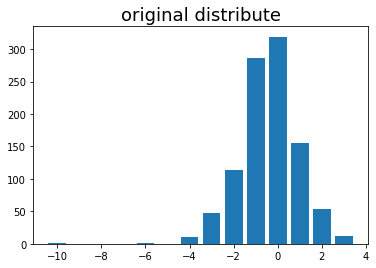

In [30]:
plt.figure('original distribute')
plt.title('original distribute', size=18)
analyzeed_samples = analyze_samples(samples.values(), 1)
plt.bar(analyzeed_samples.keys(), analyzeed_samples.values())
plt.show()

### .h5模型测试

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_0.50_160 (Functio  (None, 5, 5, 512)        829536    
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 834,677
Trainable params: 823,733
Non-trai

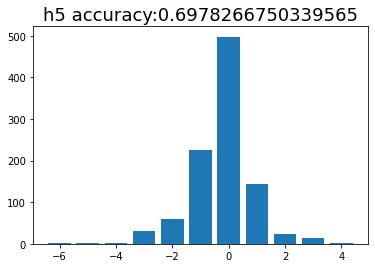

In [31]:
from keras.models import load_model

h5_model = load_model('model.h5')
h5_model.summary()

def h5_evaluator(model, image):
    result = model.predict(image[None, :, :, :], batch_size=1)
    return result[0][0]

h5_accuracy, h5_results = model_accuracy(h5_model, h5_evaluator, samples)
plt.figure('h5 model infer result distribute')
plt.title('h5 accuracy:{}'.format(h5_accuracy), size=18)
analyzeed_samples = analyze_samples(h5_results.values(), 0)
plt.bar(analyzeed_samples.keys(), analyzeed_samples.values())
plt.show()

### .tfilte模型测试

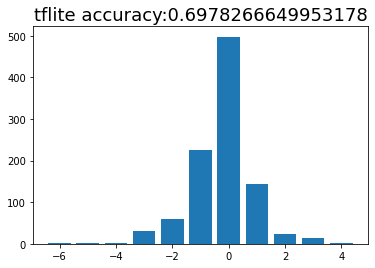

In [32]:
# Load TFLite model and allocate tensors.
tflite_model = tf.lite.Interpreter(model_path='model.tflite')
tflite_model.allocate_tensors()
# Get input and output tensors.
input_details = tflite_model.get_input_details()
output_details = tflite_model.get_output_details()

def tflite_evaluator(model, image):
    image = image.astype(np.float32)
    model.set_tensor(input_details[0]['index'], image[None, :, :, :])
    model.invoke()
    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    result = model.get_tensor(output_details[0]['index'])
    return result[0][0]

tflite_accuracy, tflite_results = model_accuracy(tflite_model, tflite_evaluator, samples)
plt.figure('tflite model infer result distribute')
plt.title('tflite accuracy:{}'.format(tflite_accuracy), size=18)
analyzeed_samples = analyze_samples(tflite_results.values(), 0)
plt.bar(analyzeed_samples.keys(), analyzeed_samples.values())
plt.show()

### .kmodel模型测试

使用kmodel对所有数据生成预测值

In [33]:
if not os.path.exists('kmodel_infer'):
    os.makedirs('kmodel_infer')

if os.name == 'posix':
    !chmod +x ncc
    !./ncc infer model.kmodel kmodel_infer --dataset calibrate
else:
    !ncc.exe infer model.kmodel kmodel_infer --dataset calibrate

流式输出内容被截断，只能显示最后 5000 行内容。
MatMul: 0.000816ms
KPUConv2D: 24.2522ms
Dequantize: 0.071248ms
Conv2D: 3.13693ms
Quantize: 0.543325ms
KPUUpload: 0.0266ms
KPUConv2D: 9.40244ms
KPUConv2D: 9.30394ms
KPUConv2D: 26.0164ms
Dequantize: 0.058346ms
Conv2D: 3.42058ms
Quantize: 0.685531ms
KPUUpload: 0.030702ms
KPUConv2D: 14.495ms
KPUConv2D: 4.8814ms
KPUConv2D: 27.6718ms
KPUConv2D: 2.35049ms
KPUConv2D: 12.5244ms
KPUConv2D: 1.99294ms
KPUConv2D: 24.8246ms
KPUConv2D: 1.04671ms
KPUConv2D: 11.7912ms
KPUConv2D: 1.01959ms
KPUConv2D: 11.4336ms
KPUConv2D: 0.969634ms
KPUConv2D: 15.1792ms
KPUConv2D: 0.989552ms
KPUConv2D: 11.4063ms
KPUConv2D: 0.956865ms
KPUConv2D: 11.3485ms
KPUConv2D: 0.971005ms
KPUConv2D: 23.5136ms
KPUConv2D: 0.546883ms
KPUConv2D: 12.8817ms
Dequantize: 0.010896ms
Reduce: 0.048748ms
Pad: 0.152957ms
Quantize: 0.056999ms
KPUUpload: 0.02417ms
KPUConv2D: 0.216915ms
Pad: 0.000879ms
Dequantize: 0.00088ms
MatMul: 0.000853ms
KPUConv2D: 26.0283ms
Dequantize: 0.05593ms
Conv2D: 3.49643ms
Quantize: 0.509531ms

计算kmodel准确率

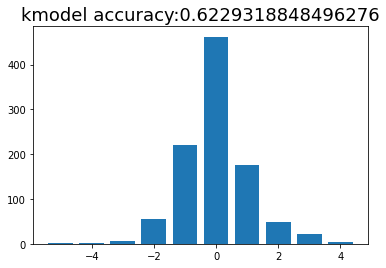

In [34]:
def kmodel_evaluator(index):
    result = np.fromfile('kmodel_infer/{}.bin'.format(index), dtype=np.float32)
    return result[0]

kmodel_accuracy, kmodel_results = model_accuracy(None, kmodel_evaluator, samples)
plt.figure('kmodel model infer result distribute')
plt.title('kmodel accuracy:{}'.format(kmodel_accuracy), size=18)
analyzeed_samples = analyze_samples(kmodel_results.values(), 0)
plt.bar(analyzeed_samples.keys(), analyzeed_samples.values())
plt.show()

# 总结

### 中间激活

In [ ]:
# from keras import models

# plt.rc('xtick', labelsize=18)                                  # 设置坐标轴字号
# plt.rc('ytick', labelsize=18) 

# data = samples[np.random.randint(len(samples))]
# img = cv2.imread("data/{}.jpg".format(data[0]))
# plt.figure()
# plt.title(data[0])
# plt.imshow(img)
# plt.show()

# model = models.load_model("model.h5")
# img_arr = np.asarray(img)

# layer_names = []                                        # 获取要显示的各层名称
# for layer in model.layers:
#     if 'flatten' in layer.name:                              # 截止到 'flatten' 层
#         break
#     layer_names.append(layer.name)

# layer_outputs = [layer.output for layer in model.layers[: len(layer_names)]]
# activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
# activations = activation_model.predict(img_arr[None, :, :, :])

# images_per_row = 4
# for layer_name, layer_activation in zip(layer_names, activations):
#     print(layer_name, layer_activation.shape)
#     n_features = layer_activation.shape[-1]
#     high = layer_activation.shape[1]
#     width = layer_activation.shape[2]
#     n_cols = n_features // images_per_row
#     display_grid = np.zeros((high * n_cols, images_per_row * width))

#     for col in range(n_cols):
#         for row in range(images_per_row):
#             channel_image = layer_activation[0, :, :, col * images_per_row + row]

#             channel_image -= channel_image.mean()                  # 美化
#             channel_image /= channel_image.std() + 1e-6              # 加 1e-6 是为了防止出现被除数为 0 的情况
#             channel_image *= 64
#             channel_image += 128
#             channel_image = np.clip(channel_image, 0, 255).astype('uint8')
#             display_grid[col * high : (col + 1) * high, row * width : (row + 1) * width] = channel_image
#     scale = 3. / high                                   # 绘制
#     plt.figure(figsize = (scale * display_grid.shape[1], scale * (display_grid.shape[0] + 1)))
#     plt.title(layer_name, size = 20)
#     plt.grid(False)
#     plt.imshow(display_grid, aspect='auto', cmap='viridis')
#     plt.savefig('figure/{}.png'.format(layer_name), bbox_inches='tight')